# Generate the motif dictionary

## !! This script generates mot_dict_curated.pkl

Bird z_r12r13_21.

In [1]:
# IMPORTS

%matplotlib inline
%run -i '/home/jovyan/pablo_tostado/bird_song/manifold_paper_analysis/all_imports.py'

h5py version > 2.10.0. Some extractors might not work properly. It is recommended to downgrade to version 2.10.0: 
>>> pip install h5py==2.10.0


# Load Data

In [2]:
sess_par = {'bird': 's_b1253_21',
            'date': '2021-06-08',
            'ephys_software': 'sglx',
            'sess': '1528_g0',
            'probe': 'probe_0',
            'sort': 0,
            }


exp_struct = fs.get_experiment_struct(bird=sess_par['bird'], 
                            date=sess_par['date'], 
                            ephys_software=sess_par['ephys_software'], 
                            sess=sess_par['sess'], 
                            sort=sess_par['sort'])

exp_struct

{'folders': {'bird': '/net2/expData/speech_bci/raw_data/s_b1253_21',
  'raw': '/net2/expData/speech_bci/raw_data/s_b1253_21/2021-06-08',
  'sglx': '/net2/expData/speech_bci/raw_data/s_b1253_21/2021-06-08/sglx/1528_g0',
  'derived': '/net2/expData/speech_bci/derived_data/s_b1253_21/2021-06-08/sglx/1528_g0',
  'sort': '/net2/expData/speech_bci/derived_data/s_b1253_21/2021-06-08/sglx/1528_g0/0'},
 'files': {'rig': '/net2/expData/speech_bci/raw_data/s_b1253_21/2021-06-08/sglx/1528_g0/rig.json',
  'wav_mic': '/net2/expData/speech_bci/derived_data/s_b1253_21/2021-06-08/sglx/1528_g0/wav_mic.wav',
  'sort_params': '/net2/expData/speech_bci/derived_data/s_b1253_21/2021-06-08/sglx/1528_g0/0/params.py'}}

# Sync the data streams using the synchronization channels

In [3]:
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}

mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')

In [4]:
# All the streams are the ones in the recording_extractors from the raw data, plus the ones generated in sglx_preprocess
all_streams = list(run_recordings.keys()) #+ ['wav'] if there was an extra audio file from UMA8??

all_syn_dict = {k: syn.get_syn_pattern(run_recordings, exp_struct, k, force=False) for k in all_streams[:]}

2024-06-19 02:12:12,258 ceciestunepipe.util.sglxsync INFO     getting syn patterns for nidq
2024-06-19 02:12:12,260 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /net2/expData/speech_bci/derived_data/s_b1253_21/2021-06-08/sglx/1528_g0/nidq_sync_dict.pkl
2024-06-19 02:12:12,272 ceciestunepipe.util.sglxsync INFO     getting syn patterns for lf_0
2024-06-19 02:12:12,273 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /net2/expData/speech_bci/derived_data/s_b1253_21/2021-06-08/sglx/1528_g0/lf_0_sync_dict.pkl
2024-06-19 02:12:12,282 ceciestunepipe.util.sglxsync INFO     getting syn patterns for ap_0
2024-06-19 02:12:12,283 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /net2/expData/speech_bci/derived_data/s_b1253_21/2021-06-08/sglx/1528_g0/ap_0_sync_dict.pkl


In [ ]:
# Get all of the streams syncched to a reference_stream
ref_stream = 'ap_0'
syn.sync_all(all_syn_dict, 'ap_0', force=False)

2024-06-19 02:12:12,295 ceciestunepipe.util.sglxsync INFO     syncing all times to ap_0
2024-06-19 02:12:12,296 ceciestunepipe.util.sglxsync INFO      synch nidq...
2024-06-19 02:12:12,296 ceciestunepipe.util.sglxsync INFO       t_prime file /net2/expData/speech_bci/derived_data/s_b1253_21/2021-06-08/sglx/1528_g0/nidq-tp.npy not found or forced computation, getting the events
2024-06-19 02:12:44,335 ceciestunepipe.util.sglxsync INFO     Event array has 34073 events


Num edges: 34073, 34073


# Generate Motif Dictionary based on Textgrid annotated labels

## mot_dict.pkl - dictionary with motif data / metadata

**‘template’**: np.array, template used to find motifs in raw recordings <br>
**‘s_f’**: int, sample_rate of the stream used to find the template <br>
**‘s_f_nidq’**: int, sample_rate of the ‘nidq’ imec binary file (and the wav_mic.npy), computed from the syn square signal <br>
**‘s_f_ap_0’**: int, sample rate of the ‘ap0’ imec binary file, computed from the syn square signal <br>
**‘start_ms’**: list, start in ms in the time scale of the wav_mic.wav file <br>
**‘start_sample_naive’**: np.array, (for debugging: start sample expected from resampling start_ms to the nidq sample rate) <br>
**‘start_sample_nidq’**: np.array, start sample in the binary (‘nidq’) imec file (= wav_mic.npy) <br>
**‘start_t_0’**:  np.array, start in sec, relative to the binary (‘nidq’) imec file <br>
**‘start_sample_ap_0’**: np.array, start sample corresponding in the probe binary imec file (‘ap0’) <br>
**‘start_t_ap_0’**: np.array, start in sec, relative to the probe binary imec file (‘ap0’) 


### Load annotated labels from TextGrid file

labels_dict = {
    'syllables 1-7': 1-7,
    'outside-of-bout silence': 8,
    'introductory notes': 10,
    'calls': 11,
    'unalbeled': 12
}

In [9]:
# Annotated Labels
textgrid_labels_path = os.path.join(exp_struct['folders']['derived'], 'behavior.TextGrid')
# Audio
mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.npy')

In [10]:
fs_audio = round(all_syn_dict['nidq']['s_f'])
txtgrid = luts.TextgridLabels(textgrid_file_path=textgrid_labels_path, audio_file_path=mic_file_name, 
                              fs_audio=fs_audio, labels_tier='labels')

np.unique(txtgrid.labels)

All intervals in the tier of interest of the .Textgrid file have been labeled (no missing labels).
Tier Name List:  ['labels']


array(['1', 'u'], dtype='<U1')

### Find start/end times of motifs based on annotated labels

In [11]:
BSP.data['z_r12r13_21']['len_motif']

0.7

In [12]:
txtgrid.fs_audio

25000

In [13]:
len_motif = BSP.data['z_r12r13_21']['len_motif']

# Find start/end samples of periods of interest (motifs)
motif_starts_audio = txtgrid.find_label_starts(target_label='1')
motif_ends_audio = motif_starts_audio + int(np.round(len_motif*txtgrid.fs_audio))

# Convert to seconds
motif_starts_audio_s = motif_starts_audio/txtgrid.fs_audio
motif_ends_audio_s = motif_ends_audio/txtgrid.fs_audio

# Create array of motifs [start, end] times
audio_array = np.array([[motif_starts_audio_s[m], motif_ends_audio_s[m]] for m in range(len(motif_starts_audio))])
    

In [14]:
len(motif_starts_audio), motif_starts_audio

(18,
 array([64262225, 64279865, 64298058, 64315914, 64334052, 64352132,
        64378417, 64396458, 64428269, 64446400, 64519696, 64537625,
        64569292, 64587203, 64689918, 64707847, 64736306, 64754351]))

Text(0.5, 1.0, 'Motifs')

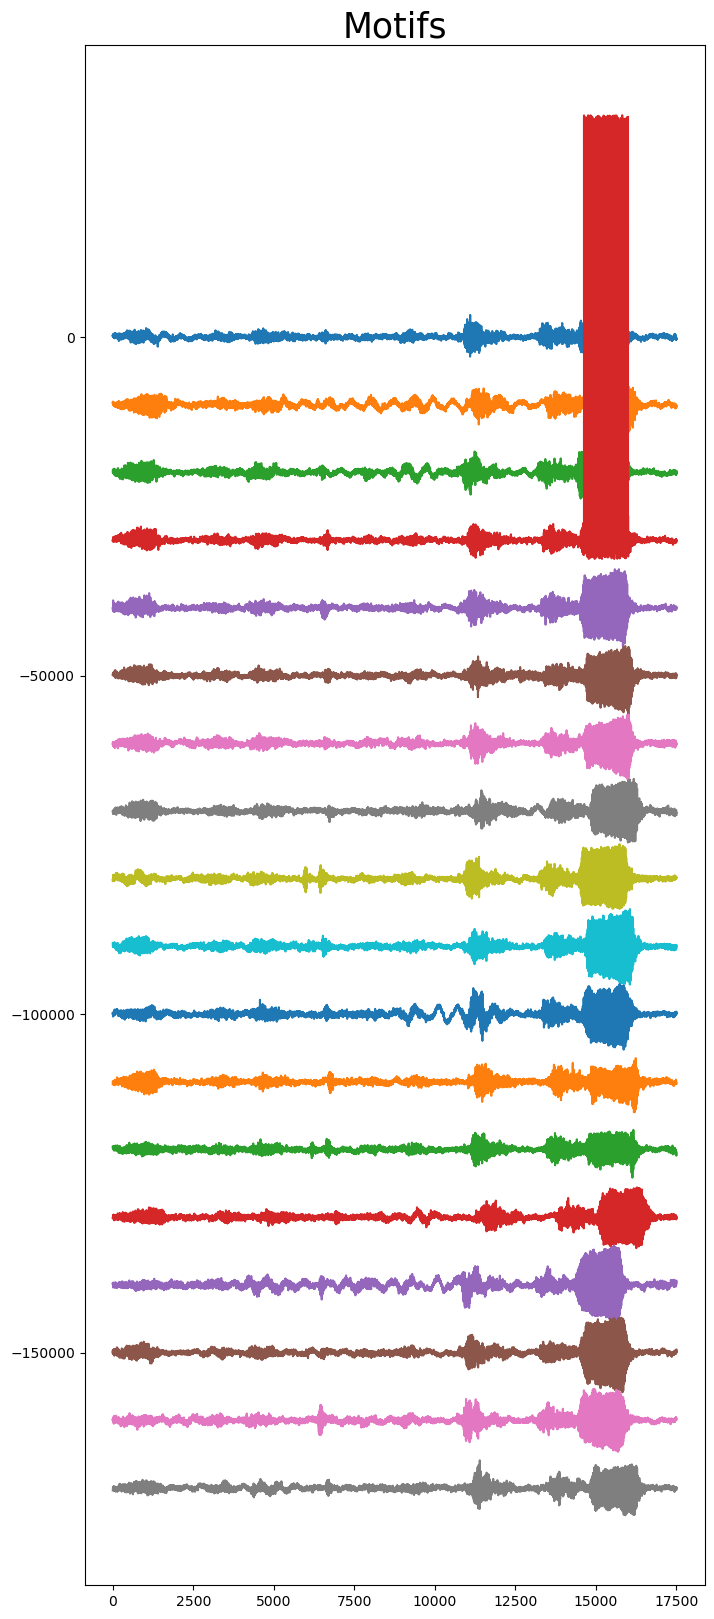

In [15]:
audio = txtgrid.audio
fs_audio = txtgrid.fs_audio

offset = 10000

##### Raw motifs
plt.figure(figsize=(8,20))
for m in range(len(motif_starts_audio)):
    plt.plot(audio[motif_starts_audio[m]:motif_starts_audio[m]+int(len_motif*fs_audio)] - m*offset)
plt.title('Motifs', fontsize=25)

### Generate motif dict based on array of audio segments of interest from synced signals

In [16]:
ad = dfpkg.AudioDictionary(audio_array, all_syn_dict)
mot_dict = ad.audio_dict

### OPTIONAL: Find start/end times of whole bouts

! Check if bouts are synced, we might need to find limits based on: all_syn_dict['nidq']['t_0']

In [17]:
# Find start/end samples of bouts based on annotated labels
bout_limits_audio = txtgrid.find_bout_limits(start_bout_label='1', end_bout_label='S')

# Convert to start/end samples of ap_0 using the sync signal
# bout_limits_ap_0 = np.round(bout_limits_audio/txtgrid.fs_audio*all_syn_dict['ap_0']['s_f']).astype(int)
bout_limits_ap_0 = []
for bl in bout_limits_audio:
    bl_ms_ap_0 = all_syn_dict['nidq']['t_p'][bl]*1000
    bl_sample_ap_0 = np.array([np.where(all_syn_dict['ap_0']['t_0'] > start)[0][0] for start in bl_ms_ap_0*0.001]).astype(np.int64).tolist()
    bout_limits_ap_0.append(bl_sample_ap_0)
bout_limits_ap_0 = np.array(bout_limits_ap_0)

# Add bout limits to mot_dataframe
mot_dict['bout_limits_sample_audio'] = bout_limits_audio
mot_dict['bout_limits_sample_ap_0'] = bout_limits_ap_0

# Plot motifs and/or bouts to check results

Text(0.5, 1.0, 'Motifs')

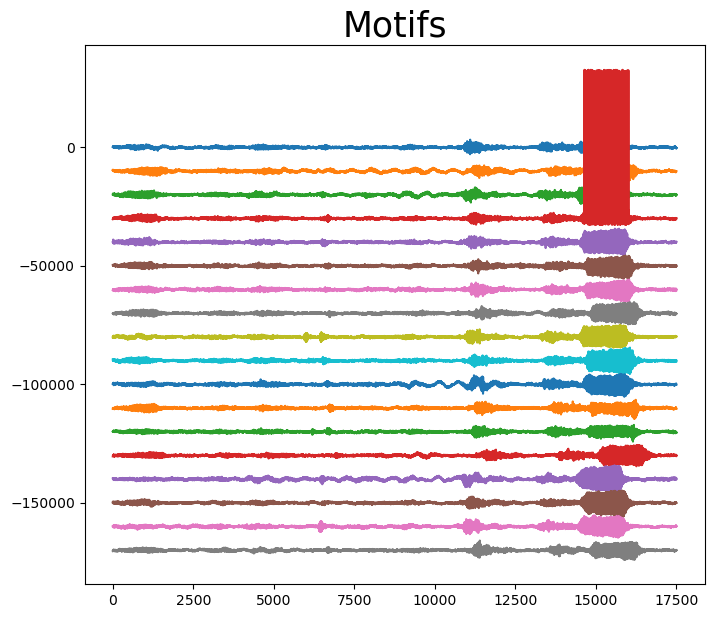

In [18]:
motif_starts = mot_dict['start_sample_naive']

audio = txtgrid.audio
fs_audio = txtgrid.fs_audio

offset = 10000

##### Raw motifs
plt.figure(figsize=(8,7))
for m in range(len(motif_starts)):
    plt.plot(audio[motif_starts[m]:motif_starts[m]+int(len_motif*fs_audio)] - m*offset)
plt.title('Motifs', fontsize=25)

In [19]:
bout_lims = mot_dict['bout_limits_sample_audio']

audio = txtgrid.audio
fs_audio = txtgrid.fs_audio
offset = 10000

##### Bouts
plt.figure(figsize=(4,7))
for m in range(len(bout_lims)):
    plt.plot(audio[bout_lims[m,0]:bout_lims[m,1]] - m*offset)


<Figure size 400x700 with 0 Axes>

# Save mot_dict.pkl

In [20]:
mot_dict_path = os.path.join(exp_struct['folders']['derived'], 'mot_dict_curated.pkl')
ad.save_audio_dict_as_pickle(mot_dict_path)

## DEPRECATED: Find motifs with template matching
- The mic stream comes from the mic, saved in sglx_pre-process
- A template is marked in that file
- A template matching runs over the whole file
- Manual curation selects the candidates

In [8]:
mic_s_f, mic_stream = wavfile.read(mic_file_path)
mic_stream.shape

FileNotFoundError: [Errno 2] No such file or directory: '/net2/expData/speech_bci/derived_data/z_w12m7_20/2020-11-05/sglx/dir_g0/wav_mic.wav'

In [28]:
mic_stream.shape[0]/mic_s_f

(141651680,)

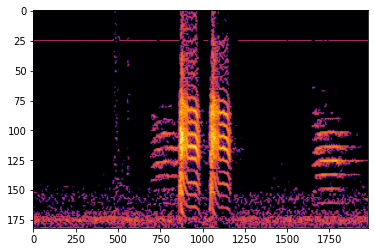

In [29]:
f, t, s = sp.ms_spectrogram(mic_stream[300000:350000], mic_s_f)
plt.imshow(np.log(s[::-1]), aspect='auto', cmap='inferno')

In [30]:
mic_s_f

25000

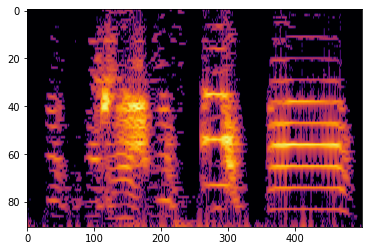

In [31]:
# I looked at the wav file and picked start: end of a motif

temp_start_s = 337.66
temp_len_s = 0.51

n_window = 256
temp_start_sample = int(temp_start_s * mic_s_f)
temp_end_sample = temp_start_sample + int(mic_s_f * temp_len_s)

# get a template from the same wav file
template = mic_stream[temp_start_sample: temp_end_sample]

#load the template
#templ_file_path = '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-30/sglx/1526_g0/mot_template.wav'
#templ_s_f, template = wavfile.read(templ_file_path)

f, t, s = sp.ms_spectrogram(template, mic_s_f, n_window=n_window, f_min=800, f_max=9000)

#plt.plot(template)
plt.imshow(np.log(s[::-1]), aspect='auto', cmap='inferno')

In [35]:
### save the template
temp_wav_name = 'mot_template.wav'

temp_wav_path = os.path.join(exp_struct['folders']['derived'], temp_wav_name)

logger.info('saving template to {}'.format(temp_wav_path))
wavfile.write(temp_wav_path, mic_s_f, template)

2022-02-10 12:01:32,330 root         INFO     saving template to /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-05/sglx/dir_g0/mot_template.wav
2022-02-10 12:01:32,330 root         INFO     saving template to /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-05/sglx/dir_g0/mot_template.wav


In [32]:
s_f_khz = int(round(mic_s_f * 0.001)) * 1000

def spectral_diff(u, v):
    spec_diff = u / np.linalg.norm(u) - v / np.linalg.norm(v)
    return np.linalg.norm(spec_diff) / np.sqrt(spec_diff.size)

In [33]:
def match_template(x, template, s_f, f_min=300, f_max=7000, n_window=128, threshold=None):
    # get the spectrogram of all of the signal
    # get the differences along the time axis
    # find peaks
    # if threshold is none, compute a reference that is the self-similarity of the pattern when shifted 20 ms
    
    # compute the difference between the template and the spectrogram
    
    # very inefficient (and memory consuming)
    logger.info('Getting spectrogram of the whole mic channel')
    
    f, t_all, s_all = sp.ms_spectrogram(x, s_f, f_min=f_min, f_max=f_max, n_window=n_window)
    
    f, t_temp, s_temp = sp.ms_spectrogram(template, s_f, f_min=f_min, f_max=f_max, n_window=n_window)
    
    if threshold is None:
        logger.info('no threhold was entered, will set it from self-similarity of pattern shifted 20ms')
        threshold = spectral_diff(s_temp[:,15:], s_temp[:,:-15])
        logger.info('threshold is {}'.format(threshold))
    
    n_s = s_temp.shape[1]
    n_a = s_all.shape[1]
    
    logger.info('getting spectral differences')
    dist_t = np.array([spectral_diff(s_temp, 
                                     s_all[:, i: i + n_s]) for i in range(n_a - n_s)])
    
    # make positive to find peaks
    inv_dist_t = 1 - dist_t
    inv_thresh = 1 - threshold
    
    peaks = signal.find_peaks(inv_dist_t, height=inv_thresh, distance=int(n_s*0.7))
    logger.info('found {} peaks'.format(peaks[0].size))
    
    return peaks, s_temp, s_all, dist_t


p, s_temp, s_all, dist_t = match_template(mic_stream.flatten(), template, s_f_khz)

2022-02-10 11:53:17,025 root         INFO     Getting spectrogram of the whole mic channel
2022-02-10 11:53:17,025 root         INFO     Getting spectrogram of the whole mic channel
2022-02-10 11:54:03,797 root         INFO     no threhold was entered, will set it from self-similarity of pattern shifted 20ms
2022-02-10 11:54:03,797 root         INFO     no threhold was entered, will set it from self-similarity of pattern shifted 20ms
2022-02-10 11:54:03,799 root         INFO     threshold is 0.009079319292259849
2022-02-10 11:54:03,799 root         INFO     threshold is 0.009079319292259849
2022-02-10 11:54:03,800 root         INFO     getting spectral differences
2022-02-10 11:54:03,800 root         INFO     getting spectral differences
2022-02-10 12:01:32,228 root         INFO     found 19 peaks
2022-02-10 12:01:32,228 root         INFO     found 19 peaks


In [34]:
p[0].size

19

In [47]:
np.array([[p[0][i], p[0][i] + s_temp.shape[1]] for i in list(range(len(p[0])))])*0.001

array([[  22.093,   22.598],
       [  39.547,   40.052],
       [  40.01 ,   40.515],
       [  40.518,   41.023],
       [ 139.046,  139.551],
       [ 336.304,  336.809],
       [ 337.134,  337.639],
       [ 337.66 ,  338.165],
       [ 338.609,  339.114],
       [3621.015, 3621.52 ],
       [3642.951, 3643.456],
       [3657.735, 3658.24 ],
       [3670.6  , 3671.105],
       [3954.908, 3955.413],
       [4224.892, 4225.397],
       [4225.61 , 4226.115],
       [4230.869, 4231.374],
       [4256.961, 4257.466],
       [4311.809, 4312.314]])

2022-02-10 13:49:00,065 root         INFO     plotting candidates
2022-02-10 13:49:00,065 root         INFO     plotting candidates


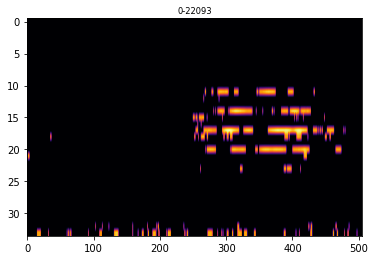

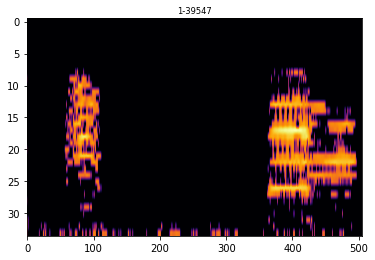

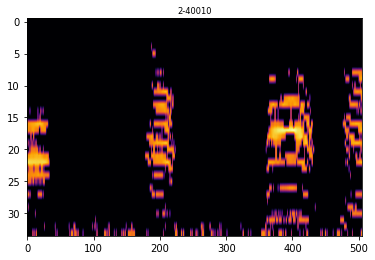

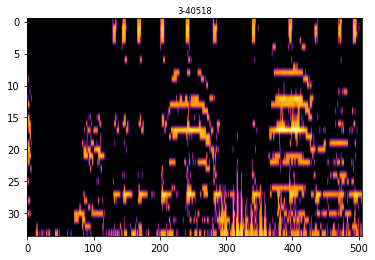

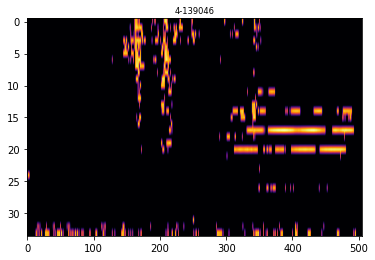

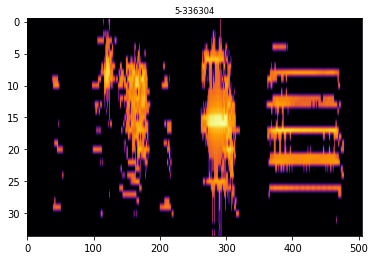

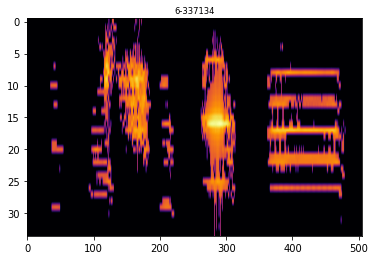

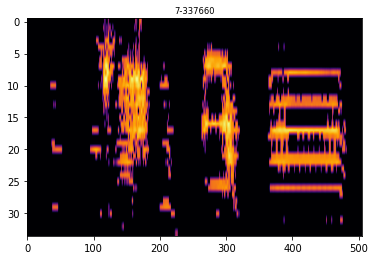

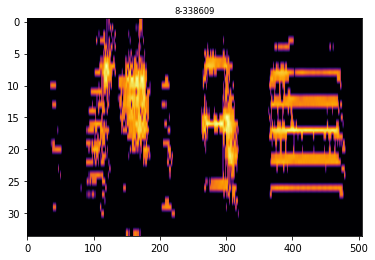

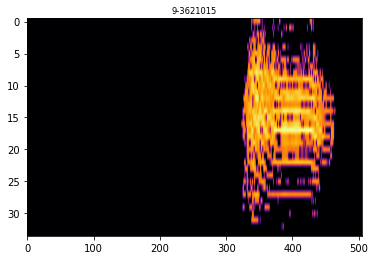

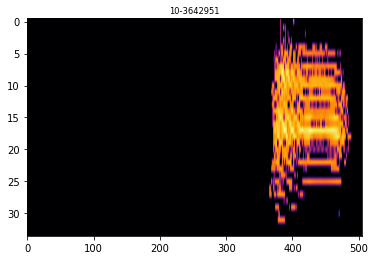

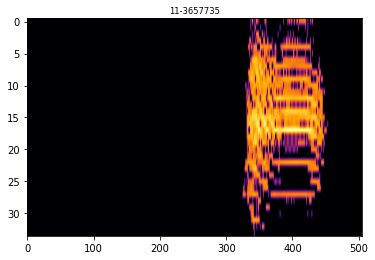

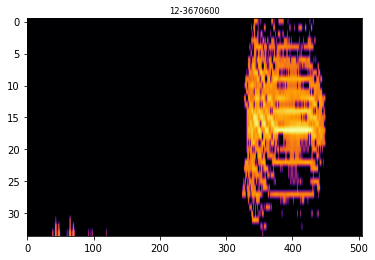

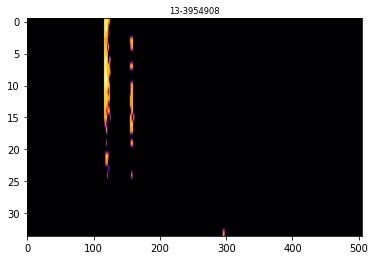

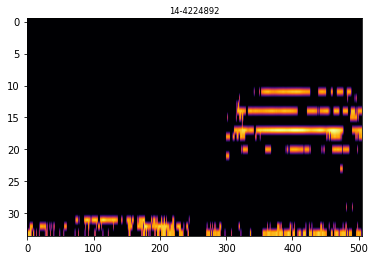

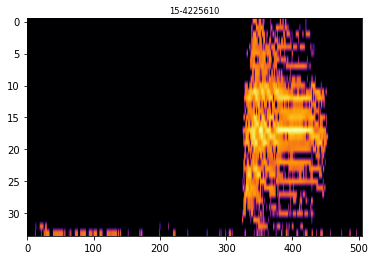

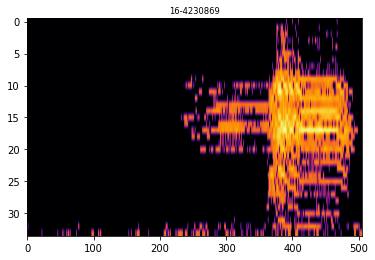

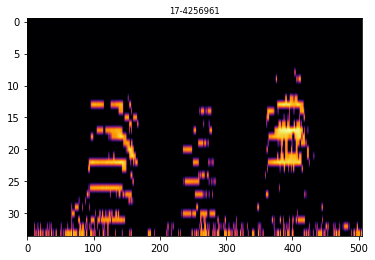

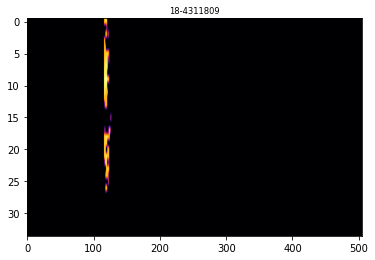

In [36]:
logger.info('plotting candidates')
for i, peak in enumerate(p[0]):
    s_peak = s_all[:, peak: peak + s_temp.shape[1]]
    fig, ax = plt.subplots()
    ax.imshow(np.log(s_peak[::-1]), aspect='auto', cmap='inferno')
    ax.set_title('{}-{}'.format(i, peak))

### Manually curate and confirm

In [40]:
# curated_peaks = np.array( list(range(len(p[0]))) ).astype(np.int16)
# curated_peaks = np.array( list(range(1,4)) + list(range(6,11)) ).astype(np.int16)
curated_peaks = np.array( list(range(5,9)) ).astype(np.int16)
# curated_peaks = np.array([0,1,2,3,5,6,7,8,9,10,11,12]).astype(np.int16)
curated_peaks

array([5, 6, 7, 8], dtype=int16)

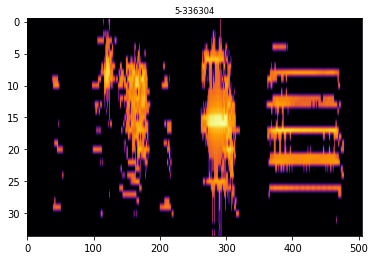

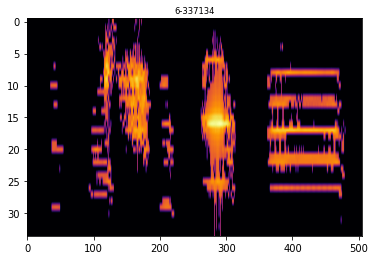

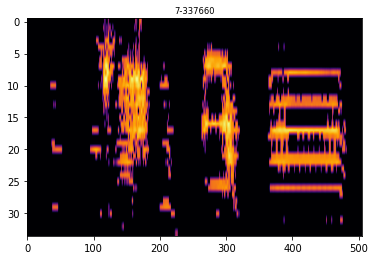

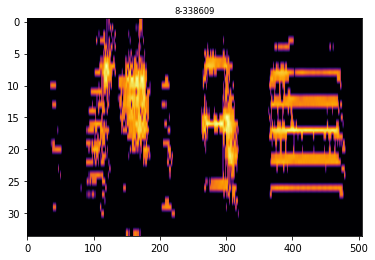

In [41]:
for i in curated_peaks:
    peak = p[0][i]
    s_peak = s_all[:, peak: peak + s_temp.shape[1]]
    fig, ax = plt.subplots()
    ax.imshow(np.log(s_peak[::-1]), aspect='auto', cmap='inferno')
    ax.set_title('{}-{}'.format(i, peak))

In [48]:
# make a mot_arr similar to the bout_arr with start:end
hand_mot_arr_s = np.array([[p[0][i], p[0][i] + s_temp.shape[1]] for i in curated_peaks])*0.001
#hand_mot_arr = (hand_mot_arr_ms * mic_s_f * 0.001).astype(np.int64)
hand_mot_arr_s

array([[336.304, 336.809],
       [337.134, 337.639],
       [337.66 , 338.165],
       [338.609, 339.114]])

In [49]:
# hand_mot_arr_s[0,1] + 0.2

# Extend the length of the motif to account for the extra syllable that's missing in some of them and was excluded from the template

# for i in range(len(hand_mot_arr_s)):
#     hand_mot_arr_s[i,1] = hand_mot_arr_s[i,1] + 0.2

# hand_mot_arr_s

### save the mot array

In [50]:
mot_arr_name = 'mot_wav_mic.npy'

mot_arr_path = os.path.join(exp_struct['folders']['derived'], mot_arr_name)

np.save(mot_arr_path, hand_mot_arr_s)

In [ ]:
fs = 44100
out_f = 'out.wav'

wavf.write(out_f, fs, samples)

In [51]:
mot_arr_path

'/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-05/sglx/dir_g0/mot_wav_mic.npy'

In [52]:
hand_mot_arr_s.shape

(4, 2)